<a href="https://colab.research.google.com/github/Artyom995/Neuro-BTC/blob/main/Neuro_BTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Цель - поставить такую задачу перед собой и ее решить, используя следующие вводные:

Это должна быть задача классического машинного обучения. Я должен продемонстрировать умение визуализировать данные. Мое решение должно быть полным, работоспособным, с развернутым описанием, так чтобы ее было не стыдно разместить в вашем резюме и GitHub. Это должно быть мое решение. Моя задача не должна быть заимствована с GitHub, Kaggle, Хабра и т.д. Использовать можно любой публичный датасет.

In [1]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=1d46a103dcde4a490dff9ae50ae4840b7c1309c5c19ac935068dfd101ee092de
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [12]:
import requests
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import ta  # библиотека для технического анализа

In [10]:
# Подключение к API https://fredaccount.stlouisfed.org/apikey для получения индекса потреб. цен и процентных ставок
api_key = '9df5d3a8938d6fc0bc488386c453c2ed'

#получение данных по индексу потребительских цен (CPI) и процентных ставках
series_id_cpi = 'CPIAUCNS'  # ID серии для CPI
series_id_interest_rate = 'FEDFUNDS'  # ID серии для процентных ставок

# URL для запроса данных
url_cpi = f'https://api.stlouisfed.org/fred/series/observations?series_id={series_id_cpi}&api_key={api_key}&file_type=json' #URL для CPI
url_interest_rate = f'https://api.stlouisfed.org/fred/series/observations?series_id={series_id_interest_rate}&api_key={api_key}&file_type=json'#URL для процентных ставок

# Выполнение запросов
response_cpi = requests.get(url_cpi) #Запрос данных по CPI
response_interest_rate = requests.get(url_interest_rate) #Запрос данных по процентным ставкам

# Преобразование данных в JSON
data_cpi = response_cpi.json() #Данные CPI
data_interest_rate = response_interest_rate.json()#Данные процентных ставок

# Преобразование данных в DataFrame
observations_cpi = data_cpi['observations'] #Создание DataFrame для CPI
df_cpi = pd.DataFrame(observations_cpi)

observations_interest_rate = data_interest_rate['observations']#Создание DataFrame для процентных ставок
df_interest_rate = pd.DataFrame(observations_interest_rate)

# Преобразование даты в формат datetime
df_cpi['date'] = pd.to_datetime(df_cpi['date']) #Для CPI
df_cpi.set_index('date', inplace=True)

df_interest_rate['date'] = pd.to_datetime(df_interest_rate['date']) #Для процентных ставок
df_interest_rate.set_index('date', inplace=True)

# Объединение данных
macro_data = pd.merge(df_cpi, df_interest_rate, left_index=True, right_index=True, suffixes=('_cpi', '_interest_rate')) #Объединение данных по индексу даты

# Вывод первых 5 строк
print(macro_data.head())

# Объединение данных
df['date'] = pd.to_datetime(df['time'])  # Преобразование времени в формат datetime
df.set_index('date', inplace=True)
# Объединение с макроэкономическими данными
df = df.join(macro_data, how='left')
# Удаление строк с NaN значениями
df.dropna(inplace=True)

           realtime_start_cpi realtime_end_cpi value_cpi  \
date                                                       
1954-07-01         2024-12-12       2024-12-12      26.9   
1954-08-01         2024-12-12       2024-12-12      26.9   
1954-09-01         2024-12-12       2024-12-12      26.8   
1954-10-01         2024-12-12       2024-12-12      26.8   
1954-11-01         2024-12-12       2024-12-12      26.8   

           realtime_start_interest_rate realtime_end_interest_rate  \
date                                                                 
1954-07-01                   2024-12-12                 2024-12-12   
1954-08-01                   2024-12-12                 2024-12-12   
1954-09-01                   2024-12-12                 2024-12-12   
1954-10-01                   2024-12-12                 2024-12-12   
1954-11-01                   2024-12-12                 2024-12-12   

           value_interest_rate  
date                            
1954-07-01            

In [21]:
# Запрос к API CryptoCompare
url = "https://min-api.cryptocompare.com/data/v2/histoday"
parameters = {
    'fsym': 'BTC',  # Символ криптовалюты
    'tsym': 'USD',  # Символ валюты
    'limit': 600,   # Количество возвращаемых данных
    'aggregate': 1
}

response = requests.get(url, params=parameters)
data = response.json()#формируем запрос к API для получения исторических данных о ценах Bitcoin (BTC) в долларах (USD) за последние 600 дней.

# Проверка успешности запроса
if data['Response'] == 'Success': #Проверяем, успешно ли выполнен запрос
    # Преобразование данных в DataFrame
    df = pd.DataFrame(data['Data']['Data'])#Преобразуем полученные данные в DataFrame для удобной работы с ними

    # Добавление технических индикаторов
    df['SMA_10'] = ta.trend.sma_indicator(df['close'], window=10)  # 10-дневная скользящая средняя
    df['SMA_50'] = ta.trend.sma_indicator(df['close'], window=50)  # 50-дневная скользящая средняя
    df['RSI'] = ta.momentum.rsi(df['close'], window=14)  # Индекс относительной силы
    df['MACD'] = ta.trend.macd(df['close'])  # MACD
    df['EMA_10'] = ta.trend.ema_indicator(df['close'], window=10)#10-дневная экспоненциальная скользящая средняя. Она придает больший вес более недавним ценам, чем более старым, что делает ее более чувствительной к изменениям цен.
    df['EMA_50'] = ta.trend.ema_indicator(df['close'], window=50)#50-дневная экспоненциальная скользящая средняя. Также более чувствительна к недавним изменениям, чем SMA.
    df['ATR'] = ta.volatility.average_true_range(df['high'], df['low'], df['close'], window=14)#Средний истинный диапазон, который измеряет волатильность рынка. Чем выше значение ATR, тем выше волатильность
    #полосs Боллинджера. Указывают на уровень перекупленности
    df['BB_upper'], df['BB_middle'], df['BB_lower'] = ta.volatility.bollinger_hband(df['close'], window=20, window_dev=2), ta.trend.sma_indicator(df['close'], window=20), ta.volatility.bollinger_lband(df['close'], window=20, window_dev=2)
    df.dropna(inplace=True)
    # Добавление объема торгов за предыдущие дни
    df['volumefrom_lag_1'] = df['volumefrom'].shift(1)  # Объем торгов за предыдущий день
    df['volumefrom_lag_3'] = df['volumefrom'].shift(3)  # Объем торгов за 3 дня назад
    df['volumefrom_lag_7'] = df['volumefrom'].shift(7)  # Объем торгов за 7 дней назад
    df['volumefrom_lag_14'] = df['volumefrom'].shift(14)  # Объем торгов за 14 дней назад
    # Удаление строк с NaN значениями
    df.dropna(inplace=True)

    # Выбор признаков и целевой переменной
    features_columns = ['open', 'high', 'low', 'volumefrom', 'volumeto',#создается список features_columns, который содержит названия столбцов, которые будут использоваться в качестве признаков (фич) для модели
                        'SMA_10', 'SMA_50', 'RSI', 'MACD', 'ATR',
                        'EMA_10', 'EMA_50', 'BB_upper', 'BB_middle', 'BB_lower',
                        'volumefrom_lag_1', 'volumefrom_lag_3', 'volumefrom_lag_7', 'volumefrom_lag_14',
                        'inflation_rate', 'interest_rate', 'value_interest_rate', 'value_cpi']  # так же убеждаемся что эти столбцы существуют

    # Фильтрация существующих столбцов
    existing_features = [col for col in features_columns if col in df.columns]#создает новый список existing_features, который содержит только те столбцы из features_columns, которые действительно существуют в DataFrame. Это важно, чтобы избежать ошибок

    # Выбор признаков
    features = df[existing_features]#DataFrame features, который содержит только те столбцы, которые были отфильтрованы на предыдущем шаге
    target = df['close']#target это целевая переменная которую мы будем предсказывать - close

    # Нормализация данных (процесс приведения значений признаков к одному масштабу, что может улучшить производительность)
    scaler = MinMaxScaler() #это метод нормализации, который преобразует данные так, чтобы они находились в диапазоне от 0 до 1
    features_scaled = scaler.fit_transform(features) #сначала вычисляет параметры (минимум и максимум) на обучающем наборе данных, а затем применяет преобразование к данным.

    # Разделение данных на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

    # Создание модели нейросети
    model = tf.keras.Sequential([ #простая нейронная сеть с двумя скрытыми слоями и одним выходным слоем. Используется функция активации leaky_relu и оптимизатор adam.
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='leaky_relu'),
        tf.keras.layers.Dense(32, activation='leaky_relu'),
        tf.keras.layers.Dense(1)
    ])

    # Компиляция модели
    model.compile(optimizer='adam', loss='mean_squared_error')#model.compile(...): Этот метод подготавливает модель к обучению. Он определяет, какой оптимизатор и функцию потерь использовать.
                                                  #Adam — алгоритм оптимизации, который адаптивно изменяет скорость обучения
                                                  #loss='mean_squared_error': Функция потерь, используемая для оценки качества модели
    # Обучение модели
    model.fit(X_train, y_train, epochs=100, batch_size=5, validation_split=0.2)#batch_size=5: Размер пакета данных, который будет использоваться для обновления весов модели

    # Оценка модели
    loss = model.evaluate(X_test, y_test)#loss: Значение функции потерь на тестовых данных
    print(f'значения потерь: {loss}')

    # Пример предсказания
    predictions = model.predict(X_test)#model.predict(): метод используется для получения предсказаний модели на новых данных
    print(predictions)
else:
    print("Ошибка при получении данных:", data['Message'])

Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3368966400.0000 - val_loss: 3198187776.0000
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3350649600.0000 - val_loss: 3187663104.0000
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3393792512.0000 - val_loss: 3154426880.0000
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3268344064.0000 - val_loss: 3086545408.0000
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3251572736.0000 - val_loss: 2972886016.0000
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2906836992.0000 - val_loss: 2809251328.0000
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2859352064.0000 - val_loss: 2590800896.0000
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2539303936.0000 - val_loss: 2321007616.0000
Epoch 9/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2274074112.0000 - val_loss: 2018889472.0000
Epoch 10/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1920837888.00

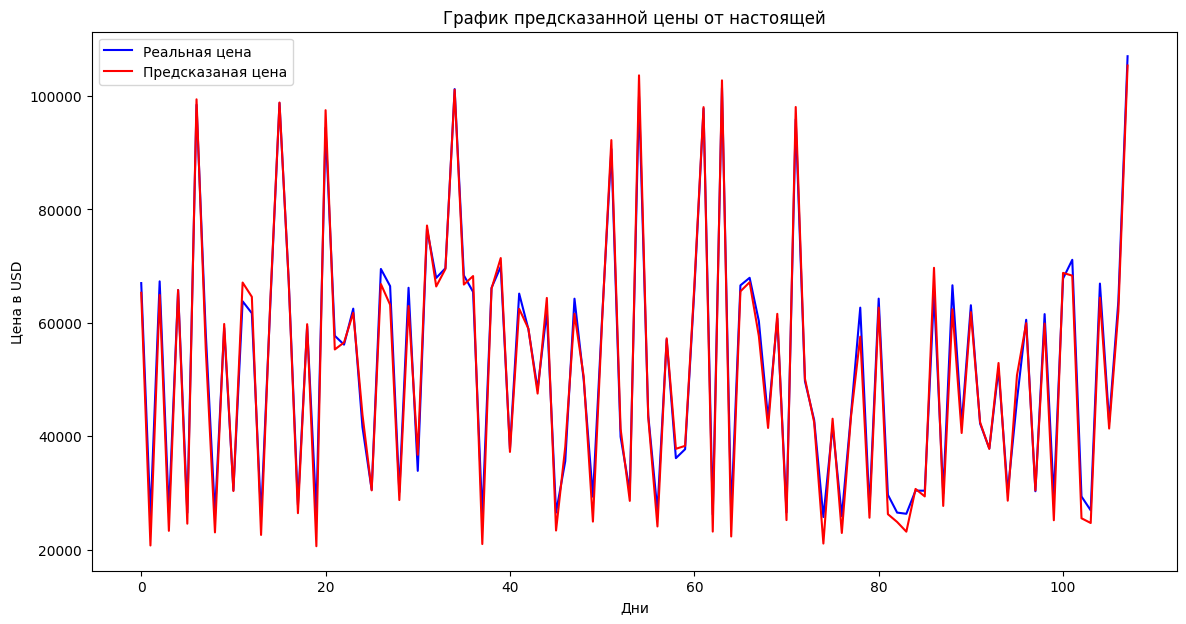

In [25]:
#real_prices - это массив с реальными значениями
real_prices = y_test.values  # y_test - это реальные значения

# Преобразование предсказаний в одномерный массив
predicted_prices = predictions.flatten()

# Визуализация
plt.figure(figsize=(14, 7))
plt.plot(real_prices, label='Реальная цена', color='blue')
plt.plot(predicted_prices, label='Предсказаная цена', color='red')
plt.title('График предсказанной цены от настоящей')
plt.xlabel('Дни')
plt.ylabel('Цена в USD')
plt.legend()
plt.show()

[ 1707.63  5061.03  2395.13  3231.34    -5.1   1919.23  -963.29  2781.83
  3132.02  -682.22   138.52 -3308.1  -2888.98  3208.9   -555.36   -81.04
    44.92  1465.78  -330.32  5787.2  -3106.    2409.47  -375.54   738.11
 -2209.82   104.55  2665.73  3288.27  1392.6   3214.6  -2831.96  -596.92
  1505.62   124.96   114.59  1612.49 -2786.83  4873.75   150.68 -1527.86
   541.17  2682.36  -103.28   767.91 -2358.81  3158.5  -2528.74  2661.7
  -589.12  4376.27   417.57 -1582.94 -1412.78  1663.15 -3724.1    340.82
  2746.8   -222.63 -1645.69  -595.44  -668.41  -262.02  3007.78 -1310.93
  3904.17  1056.54   781.32  2655.04  1606.93  -805.05  1360.75 -2187.66
  -439.32   403.5   4672.79 -1298.6   2958.71   406.13  5109.93  1558.87
  1586.03  3411.25  1651.34  3154.92  -289.89  1000.14 -4446.61  2168.76
  4230.08  1550.31  1212.54  -208.68    65.55 -1078.59  1481.02 -4393.91
   599.6   -141.29  1672.78  3963.27 -1003.24  2789.92  3840.42  2230.34
  2487.16  1138.09  1771.94  1639.42]


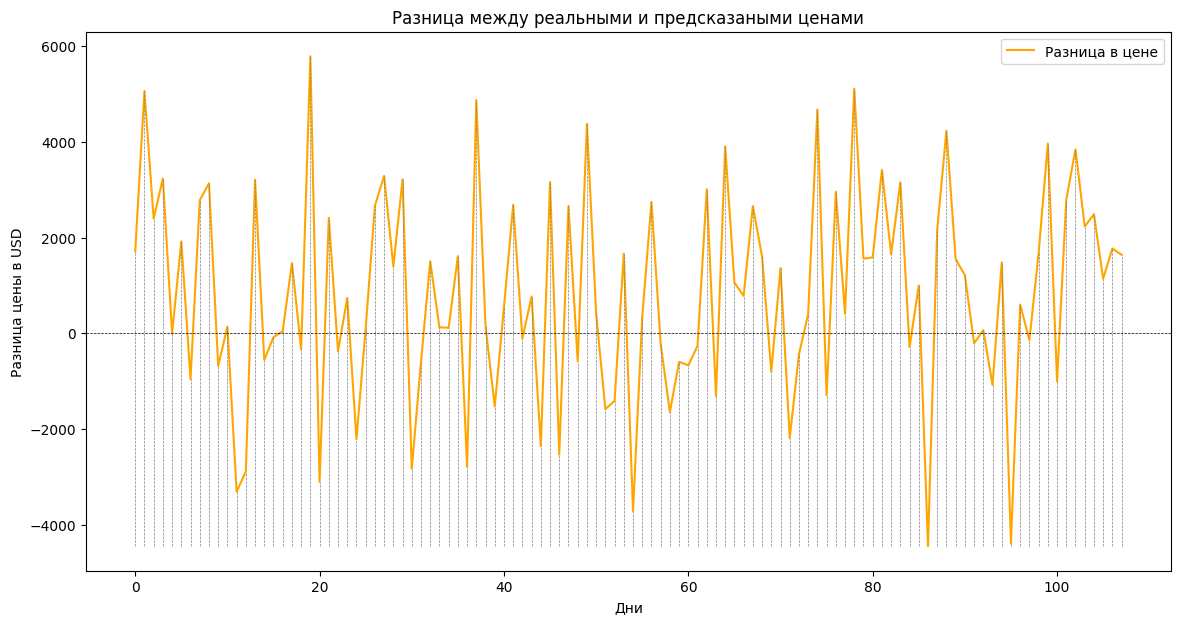

In [28]:
# массив реальных цен закрытия для тестовой выборки
real_prices = y_test.values  # y_test - это реальные значения

# Преобразование предсказаний в одномерный массив
predicted_prices = predictions.flatten()

# Вычисление разницы между реальными и предсказанными ценами
np.set_printoptions(suppress=True)  # Отключаем научную нотацию чтобы не выводились значения 1.70763e+03 5.06103e+03 2.39513e+03 3.23134e+03
price_difference = real_prices - predicted_prices
price_difference_rounded = np.round(price_difference, 2)#округлили до 2 знака
print(price_difference_rounded)
# Визуализация разницы
plt.figure(figsize=(14, 7))
plt.plot(price_difference, label='Разница в цене', color='orange')
plt.title('Разница между реальными и предсказаными ценами')
plt.xlabel('Дни')
plt.ylabel('Разница цены в USD')

# Добавление штрихпунктирных линий
for i in range(len(price_difference)):
    plt.vlines(x=i, ymin=min(price_difference), ymax=price_difference[i], color='gray', linestyle='--', linewidth=0.5)

plt.axhline(0, color='black', linewidth=0.5, linestyle='--')  # Линия на уровне 0 для удобства
plt.legend()
plt.show()